In [1]:
# !pip3 install numpy

In [2]:
# !pip3 install matplotlib

In [3]:
# !pip3 install opencv-python

In [4]:
# !pip3 install Pillow

In [5]:
# !pip3 install ultralytics

In [6]:
# !pip3 install mediapipe

In [7]:
import cv2
import virtual_board_all 
from ultralytics import YOLO
import mediapipe as mp
import os
import time
from cvzone_hand import HandDetector
import process_frame
import matrix_to_pieces
import tasks
import warnings
import store_as_video
from belief import GroupSkillBelief, plot_beliefs

**This file is the main file to run for circuit detection and verification.**

#### Implementation on Video

In [8]:
def create_beliefs(task):
    beliefs = {}
    task.sids
    
    for sid in task.sids:
        skill = tasks.sid_skill_map[sid]
        skill_probs = skill.skill_probs
        skill_belief = GroupSkillBelief(sname=skill.skill_name,
                                        sid=sid, 
                                        uids=task.uids, 
                                        p_L_0=0.5, 
                                        p_S=skill_probs.prob_slipping, 
                                        p_G=skill_probs.prob_guessing, 
                                        p_T=skill_probs.prob_learning,
                                        n=10, 
                                        discussion_time=task.discussion_time,
                                        solve_time=task.solve_time)
        beliefs[sid] = skill_belief
    return beliefs

In [9]:
task = 1
source = "raw_videos/raw_video_45.mp4" #'raw_videos/test4.mp4' #1 #'raw_videos/test2.mp4' #'raw_videos/raw_video_45.mp4'
store = False # if source != 0 and source != 1 else True
show = True
first_viable_frame = 0

{(0, 0): array([126,  77], dtype=int64), (0, 1): array([165,  77], dtype=int64), (0, 2): array([203,  77], dtype=int64), (0, 3): array([242,  77], dtype=int64), (0, 4): array([281,  77], dtype=int64), (0, 5): array([319,  77], dtype=int64), (0, 6): array([358,  77], dtype=int64), (1, 0): array([126, 117], dtype=int64), (1, 1): array([165, 117], dtype=int64), (1, 2): array([203, 117], dtype=int64), (1, 3): array([242, 117], dtype=int64), (1, 4): array([281, 117], dtype=int64), (1, 5): array([319, 117], dtype=int64), (1, 6): array([358, 117], dtype=int64), (2, 0): array([126, 156], dtype=int64), (2, 1): array([165, 156], dtype=int64), (2, 2): array([203, 156], dtype=int64), (2, 3): array([242, 156], dtype=int64), (2, 4): array([281, 156], dtype=int64), (2, 5): array([319, 156], dtype=int64), (2, 6): array([358, 156], dtype=int64), (3, 0): array([126, 196], dtype=int64), (3, 1): array([165, 196], dtype=int64), (3, 2): array([203, 196], dtype=int64), (3, 3): array([242, 196], dtype=int64),

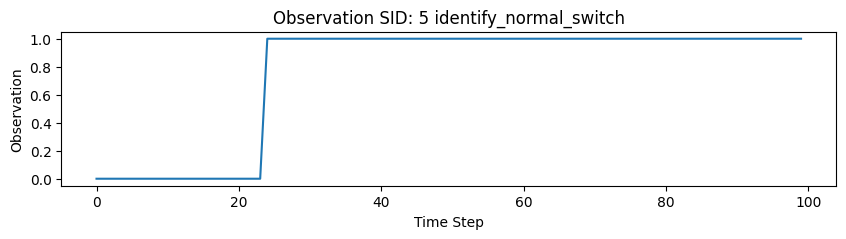

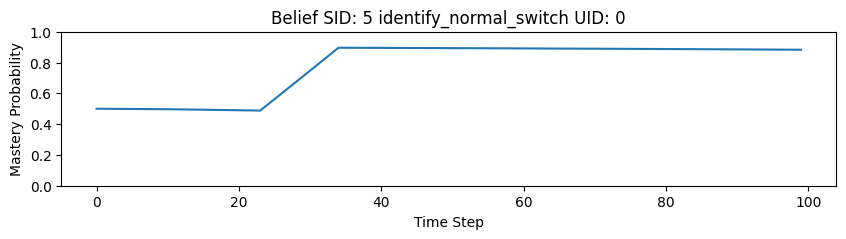

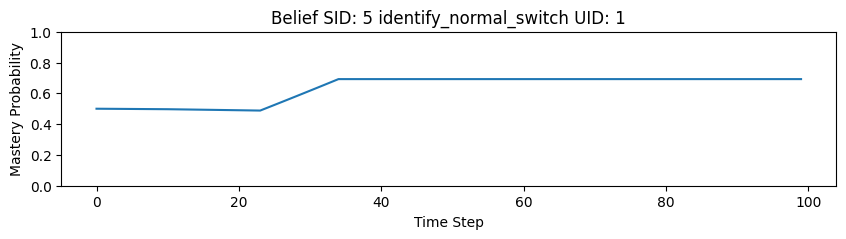

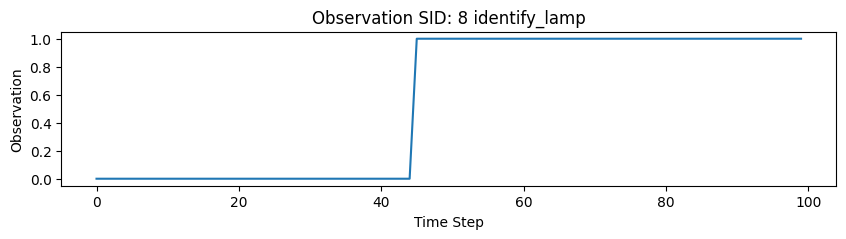

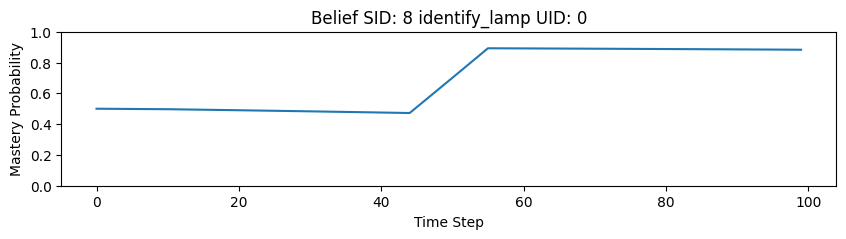

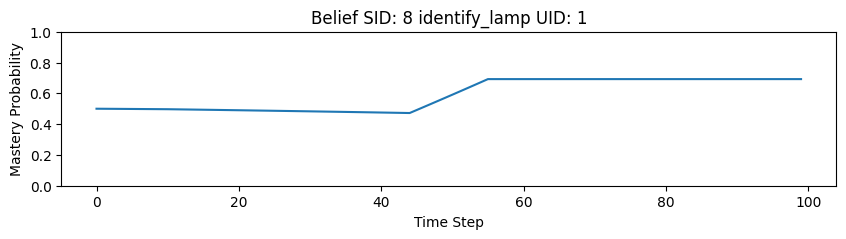

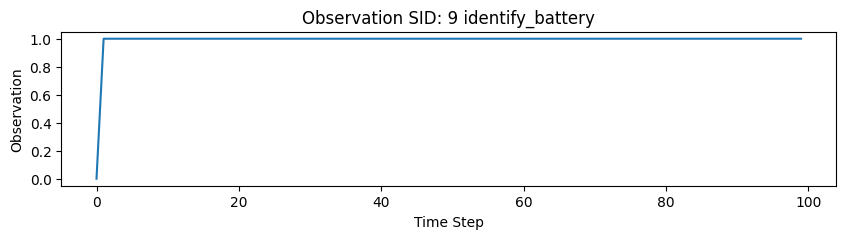

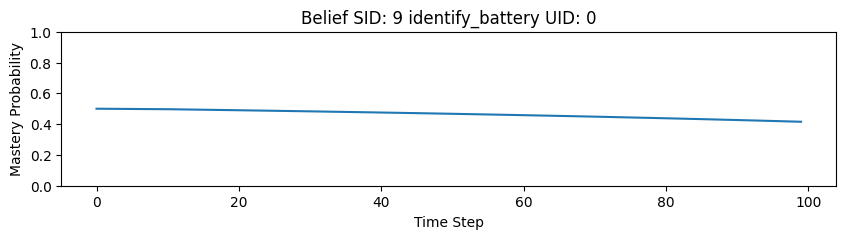

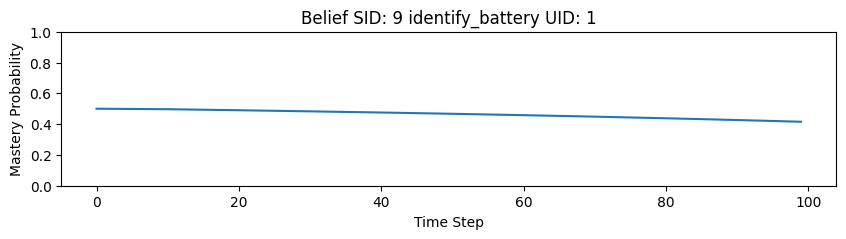

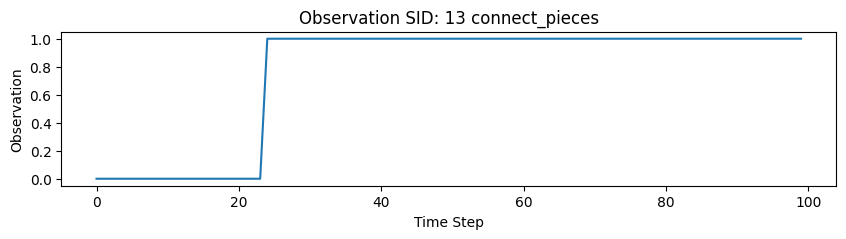

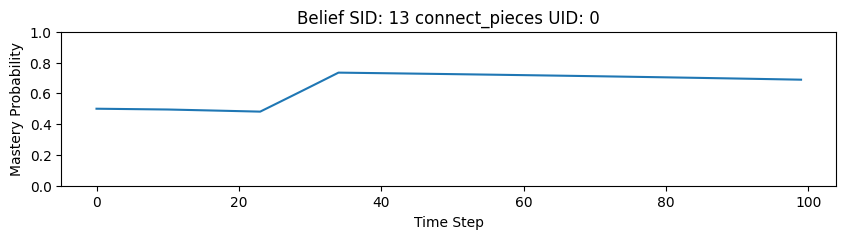

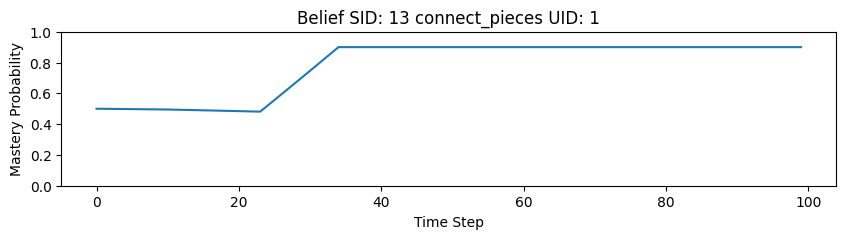

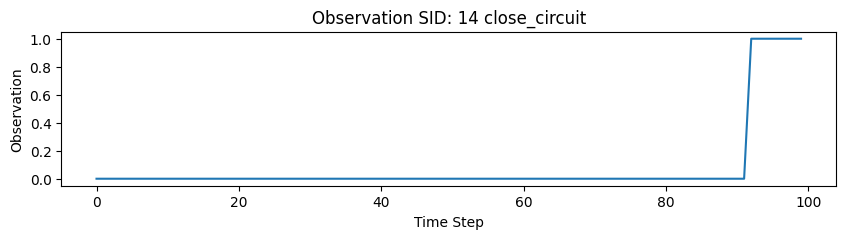

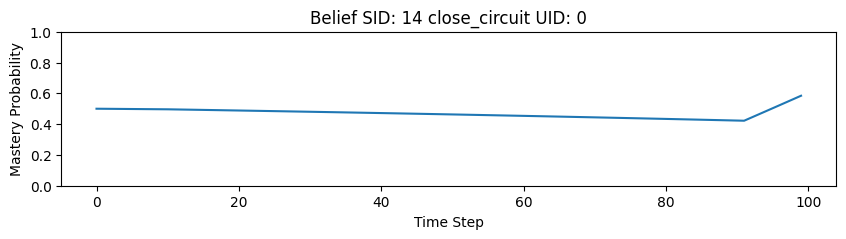

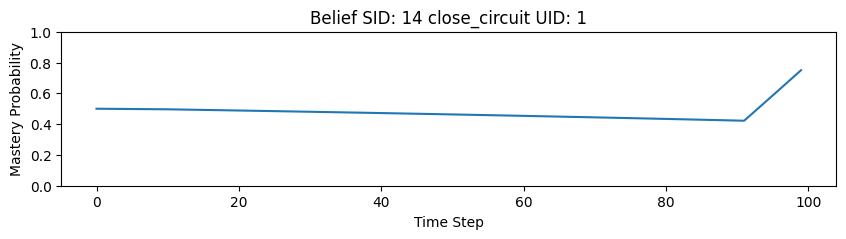

In [10]:
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf.symbol_database")

cap = cv2.VideoCapture(source)

# pre-trained YOLO model and hand model
model = YOLO('best (8).pt')
detector = HandDetector(detectionCon=0.5, maxHands=4)

# initialize
uids = [0, 1]
time_step_index = 0
board = matrix_to_pieces.initialise_board(90)
task = tasks.get_task("task1", uids)

# store video
if store: writer = store_as_video.store_video(cv2.VideoCapture(source))

hands_over_board = {}
for uid in uids:
    hands_over_board[uid] = []
changed = False

beliefs = create_beliefs(task)

while True:
    # Capture a frame
    ret, frame = cap.read()
    if not ret:
        print("Camera Connection Failed")
        break

    if show: cv2.imshow("Uncropped Image", frame)
    # Store video
    if store: writer.write(frame)

    if time_step_index >= first_viable_frame:
        
        # Focus on board
        frame_for_board, frame_for_hand = process_frame.crop_frame(frame)
        #frame_for_board, frame_for_hand = process_frame.crop_frame_home(frame)
        # frame_for_board, frame_for_hand = process_frame.crop_frame_general(frame, crop_size=320)
        if show: cv2.imshow("Board Frame Image", frame_for_board)
        if show: cv2.imshow("Hand Frame Image", frame_for_hand)
        
        # We draw pegs on the board using the first frame. This is done because we assume that the board will remain stationary
        # throughout the video. Drawing the pegs in the initial frame helps us avoid any shift or misalignment of the
        # pegs when a piece moves near or past the edge of the board.
        if time_step_index == first_viable_frame:
            matrix_to_recolor, peg_size, frame_tilt, frame_circle, angle = virtual_board_all.draws_pegs_on_rotated_board(frame_for_board)
        else:
            frame_tilt = virtual_board_all.tilt(frame_for_board, angle) 

        if show: cv2.imshow("Board with Pegs", frame_circle)

        # Detecting hand
        hands, img = detector.findHands(frame_for_hand)
        if show: cv2.imshow("Hand Detected Large Image", img)

        if not hands:
            matrix, data, output = process_frame.process_frame_with_yolo(frame_tilt, model, matrix_to_recolor, peg_size)

            user_0_time = len(hands_over_board[0])
            user_1_time = len(hands_over_board[1])
            total_time = user_0_time + user_1_time
            if total_time != 0:
                user_0_contribution = user_0_time / total_time
                user_1_contribution = user_1_time / total_time
            else:
                user_0_contribution = 0
                user_1_contribution = 0

            board, changed = matrix_to_pieces.data_to_board(board, data, output, frame_tilt, angle, {0: user_0_contribution, 1: user_1_contribution})
            
            
            task.check_skills(board)
           
        else:
            # hand on board
            print("\033[91mHand On Board!\033[0m")
            hands, img = detector.findHands(frame_for_hand) #NOTEEEEE
            if show: cv2.imshow("Hand Detected Image", img)
            # for all hands, store the history of its center
            for hand in hands:
                if hand['type'] == "ID: 0":
                    hands_over_board[0].append(time_step_index)
                else:
                    hands_over_board[1].append(time_step_index)

        if changed:
            hands_over_board = {}
            for uid in uids:
                hands_over_board[uid] = []
            changed = False

        for sid in beliefs:
            c_ts = {}
            for uid in uids:
                c_ts[uid] = task.cs[sid][uid]
            beliefs[sid].step(task.os[sid], c_ts)

        

    time.sleep(0.1) 
    # Check for the 'q' key press to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

    if time_step_index > task.discussion_time + task.solve_time:
        break
    # if time_step_index % 100 == 0:
    #     print(time_step_index)
    #     plot_beliefs(beliefs=beliefs)
    time_step_index += 1
    
print("OUTPUTS: ")
print(board.history)
plot_beliefs(beliefs=beliefs)

# Release the webcam and close the windows
cap.release()
if store: writer.release() 
cv2.destroyAllWindows()